# Introduction

Captum (“comprehension” in Latin) is an open source, extensible library for model interpretability built on PyTorch.

Captum provides state-of-the-art algorithms, including Integrated Gradients, to provide researchers and developers with an easy way to understand which features are contributing to a model’s output.

Captum helps ML researchers more easily implement interpretability algorithms that can interact with PyTorch models. For model developers, Captum can be used to improve and troubleshoot models by facilitating the identification of different features that contribute to a model’s output in order to design better models and troubleshoot unexpected model outputs.

# Training CIFAR-10 Classifier

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    net.load_state_dict(torch.load('cifar_torchvision.pt'))
else:
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), 'cifar_torchvision.pt')

Using existing trained model


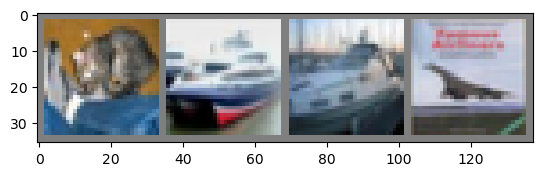

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car  ship plane


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = net(images.to(device = device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [7]:
ind = 3

input = images[ind].unsqueeze(0).to(device)
input.requires_grad = True

In [8]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
)

In [9]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [10]:
saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [11]:
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0536], device='cuda:0', dtype=torch.float64)


In [12]:
ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [13]:
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

c:\Users\197796\Anaconda3\envs\torch\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Original Image
Predicted: plane  Probability: 0.869112491607666


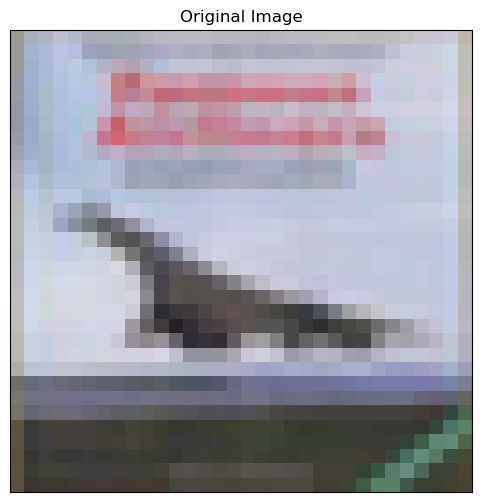

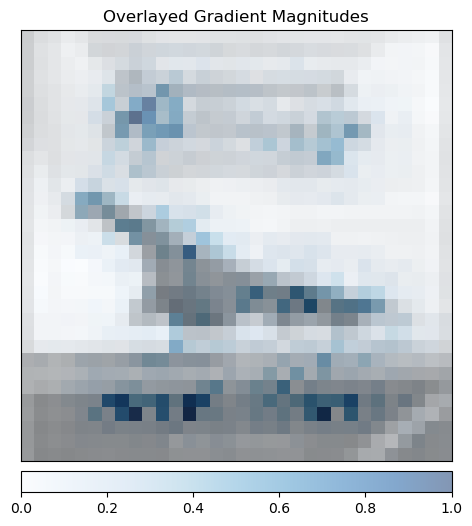

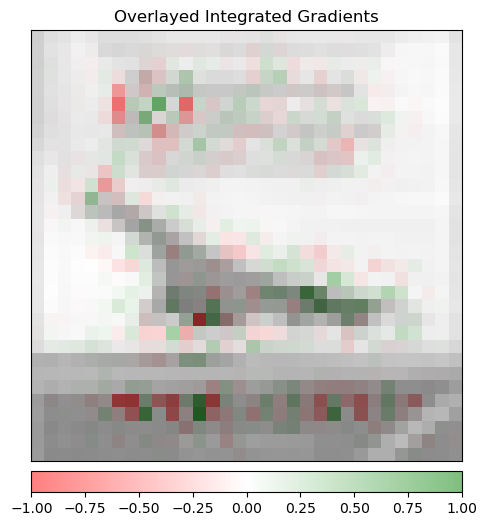

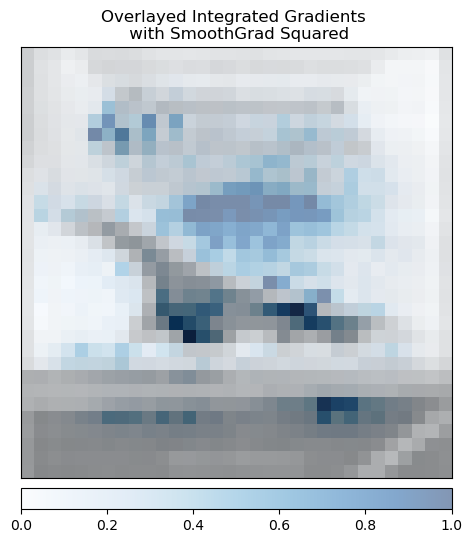

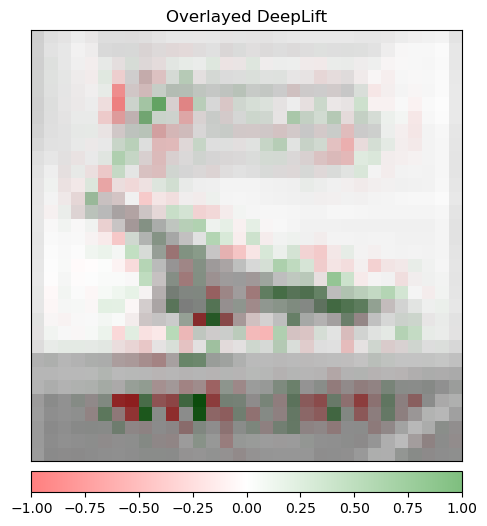

In [14]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")

# Model Interpretation for Pretrained ResNet Model

In [15]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [16]:
model = models.resnet18(pretrained=True)
model = model.eval()

c:\Users\197796\Anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\197796\Anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
with open("imagenet_class_index.json") as json_data:
    idx_to_labels = json.load(json_data)

In [19]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('img/orange_cat.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [20]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: tiger_cat ( 0.9241344928741455 )


In [21]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

Predicted: tiger_cat ( 0.9241344928741455 )


### Gradient-based attribution 

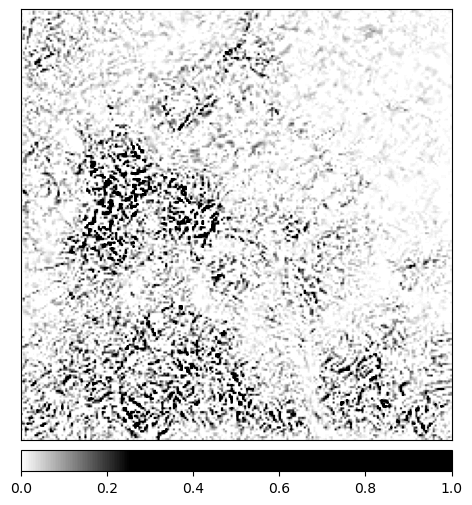

In [22]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

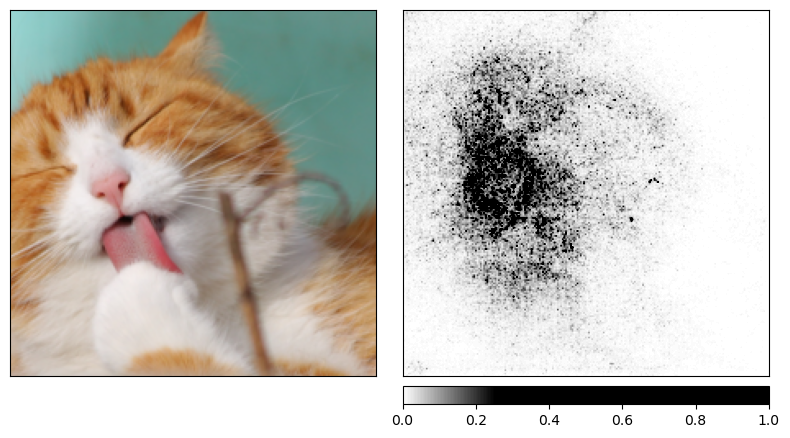

In [23]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

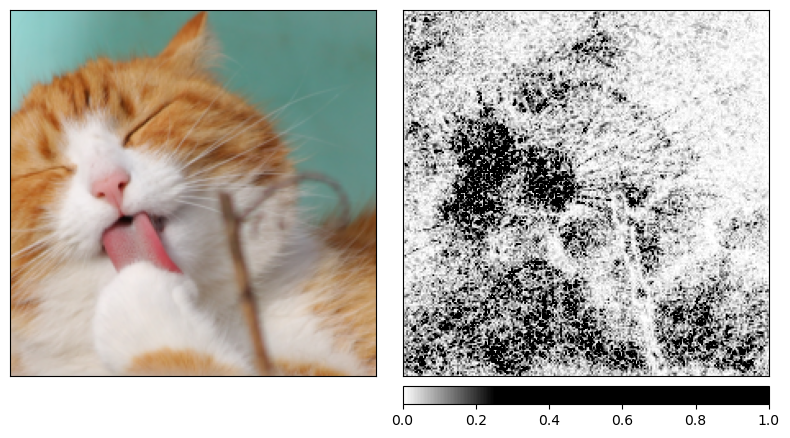

In [24]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

### Occlusion-based attribution

In [25]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

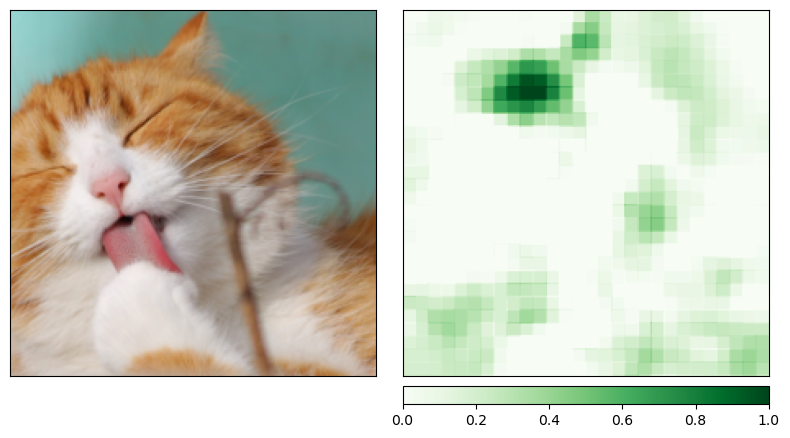

In [26]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

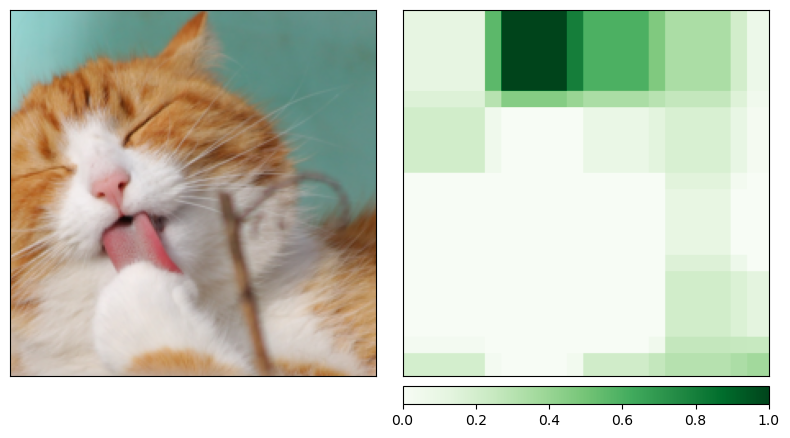

: 

In [27]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

# Feature Ablation to Inspect ResNet Decisions

In [1]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision import models

from captum.attr import visualization as viz
from captum.attr import FeatureAblation

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import os
import json

In [2]:
resnet = models.resnet18(pretrained=True)
resnet = resnet.eval()

c:\Users\197796\Anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\197796\Anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
root = "./VOC"
dataset = torchvision.datasets.VOCSegmentation(root, year='2012', image_set='train', download=True, transform=None, target_transform=None)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./VOC\VOCtrainval_11-May-2012.tar to ./VOC


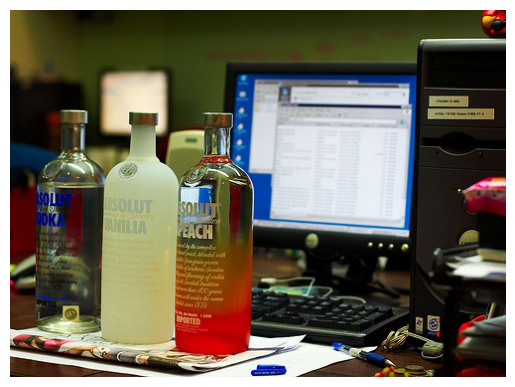

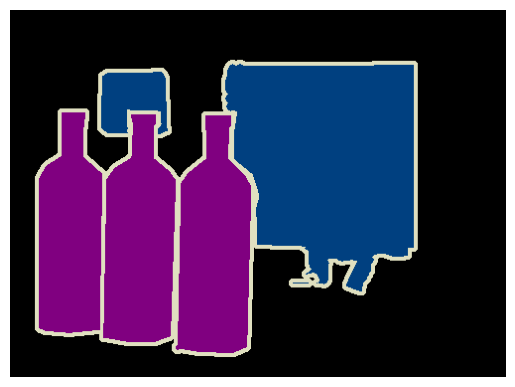

In [5]:
sample_ind = 91

img = Image.open(dataset.images[sample_ind])
plt.imshow(img); plt.axis('off'); plt.show()
mask_img = Image.open(dataset.masks[sample_ind])
plt.imshow(mask_img); plt.axis('off'); plt.show()

In [6]:
with open("imagenet_class_index.json") as json_data:
    idx_to_labels = json.load(json_data)

In [9]:
# uses torchvision transforms to convert a PIL image to a tensor and normalize it
img_to_resnet_input = T.Compose([
 T.ToTensor(),
 T.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )    
])

def classify(img, print_result=True):
    output = resnet(img_to_resnet_input(img).unsqueeze(0))
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    prediction_score.squeeze_()
    pred_label_idx.squeeze_()
    if print_result:
        with open("imagenet_class_index.json") as json_data:
            idx_to_labels = json.load(json_data)
        predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
        print('Predicted:', predicted_label, "id =", pred_label_idx.item(), 'with a score of:', prediction_score.squeeze().item())
    return pred_label_idx.item(), prediction_score.item()

In [10]:
predicted_class, prediction_score = classify(img)

Predicted: wine_bottle id = 907 with a score of: 0.12470867484807968


## Inspecting influential image parts behind the classification output

With the availability of a segmentation mask, we can quickly exclude parts of the image to see how they affect the classification output.

The Feature Ablation algorithm in Captum enables ablating a number of input features together as a group. This is very useful when dealing with images, where each color channel in each pixel is an input feature. To define our desired groups over input features, all we need is to provide a feature mask.

In [11]:
# convert the mask image to a numpy array of the expected shape (count, channels, height, width)
feature_mask = np.array(mask_img.getdata()).reshape(1, 1, mask_img.size[1], mask_img.size[0])

In [12]:
print(np.unique(feature_mask))

# These ids correspond to the VOC labels for background, bottle, tvmonitor and void.

[  0   5  20 255]


In [13]:
feature_mask[feature_mask == 5] = 1 # feature group for bottle
feature_mask[feature_mask == 20] = 2 # feature group for tvmonitor
feature_mask[feature_mask == 255] = 3 # feature group for void

In [14]:
ablator = FeatureAblation(resnet)

attribution_map = ablator.attribute(
    img_to_resnet_input(img).unsqueeze(0),
    target=predicted_class,
    feature_mask=torch.tensor(feature_mask))

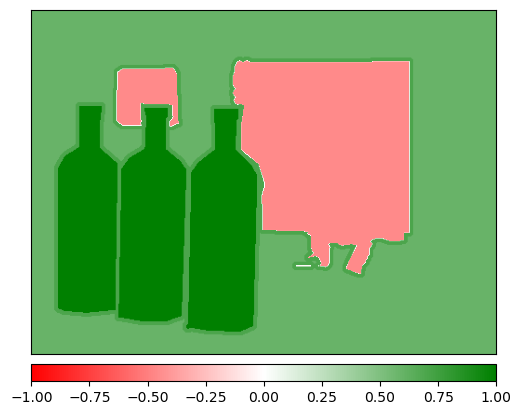

In [15]:
attribution_map = attribution_map.squeeze().cpu().detach().numpy()
# adjust shape to height, width, channels 
attribution_map = np.transpose(attribution_map, (1,2,0))
_ = viz.visualize_image_attr(attribution_map,
                             method="heat_map",
                             sign="all",
                             show_colorbar=True)

### Inspecting influential image parts for alternative classification

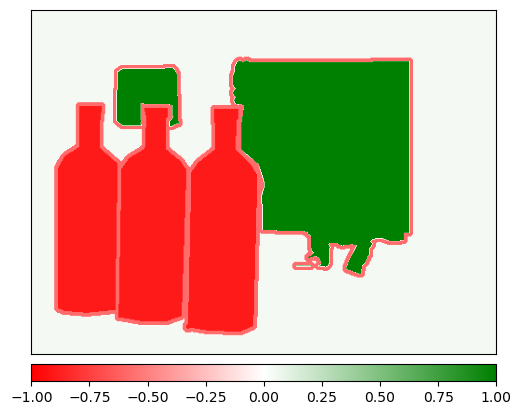

In [16]:
attribution_map = ablator.attribute(
    img_to_resnet_input(img).unsqueeze(0),
    target=664,
    feature_mask=torch.tensor(feature_mask))

attribution_map = attribution_map.squeeze().cpu().detach().numpy()
# adjust shape to height, width, channels 
attribution_map = np.transpose(attribution_map,  (1,2,0))

_ = viz.visualize_image_attr(attribution_map,
                             method="heat_map",
                             sign="all",
                             show_colorbar=True)

ImageNet does have a class for a TV monitor with class_id = 664 according to the idx_to_labels map we loaded in section 1.

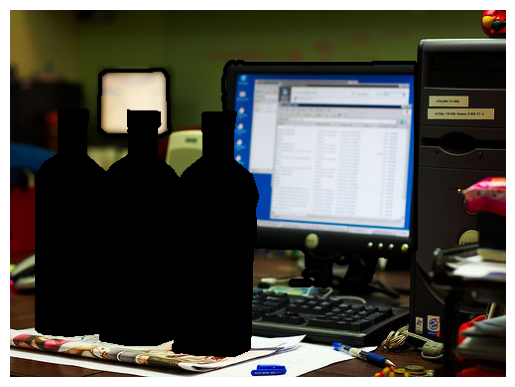

In [18]:
import cv2

cV2_mask = np.array(feature_mask)
cV2_mask[feature_mask == 0] = 1
cV2_mask[feature_mask == 1] = 0
cV2_mask[feature_mask == 2] = 1
cV2_mask[feature_mask == 3] = 0
cV2_mask = np.expand_dims(cV2_mask.squeeze(), axis=2).astype(np.uint8)

img_arr = np.transpose(T.ToTensor()(img).numpy(),  (1,2,0))
img_without_bottles = cv2.bitwise_and(img_arr, img_arr, mask=cV2_mask)
plt.imshow(img_without_bottles); plt.axis('off'); plt.show()

In [19]:
classify(img_without_bottles)

Predicted: desktop_computer id = 527 with a score of: 0.10873223841190338


(527, 0.10873223841190338)

In [20]:
output = resnet(img_to_resnet_input(img_without_bottles).unsqueeze(0))
output = F.softmax(output, dim=1)
torch.topk(output, 5)

torch.return_types.topk(
values=tensor([[0.1087, 0.0971, 0.0961, 0.0801, 0.0727]], grad_fn=<TopkBackward0>),
indices=tensor([[527, 681, 673, 782, 664]]))